In [6]:
using Revise
using RadiativeTransfer
using RadiativeTransfer.PhaseFunction
using RadiativeTransfer.RTM

# ? Should we make a wrapper around LogNormal?
using Distributions
# using BenchmarkTools

## 
## STEP 1: Create the Aerosol
## 

# Aerosol particle distribution and properties 
μ  = 0.3                # Log mean radius
σ  = 6.82               # Log stddev of radius
r_max = 30.0            # Maximum radius
nquad_radius = 2500     # Number of quadrature points for integrating of size dist.
nᵣ = 1.3                # Real part of refractive index
nᵢ = 0.001              # Imag part of refractive index
Ltrunc = 20             # Truncation 
size_distribution = LogNormal(log(μ), log(σ))

# Create the aerosol
aero = make_univariate_aerosol(size_distribution, r_max, nquad_radius, nᵣ, nᵢ)


UnivariateAerosol{Float64,Float64}(LogNormal{Float64}(μ=-1.2039728043259361, σ=1.9198594718553708), 30.0, 2500, 1.3, 0.001)

In [7]:
# Define some details, run aerosol optics
λ = 0.55   # Incident wavelength
polarization_type = Stokes_IQUV()
truncation_type   = δBGE(Ltrunc, 2.0)
model_NAI2 = make_mie_model(NAI2(), aero, λ, polarization_type, truncation_type)
aerosol_optics_NAI2 = compute_aerosol_optical_properties(model_NAI2);

┌ Info: Fraction of size distribution cut by max radius: 0.8226655996648291 %
└ @ RadiativeTransfer.PhaseFunction /Users/sanghavi/GDrive/code/github/RadiativeTransfer.jl/src/PhaseFunction/mie_helper_functions.jl:263
Computing PhaseFunctions Siewert NAI-2 style ...100%|███| Time: 0:00:01


In [8]:
Nquad, qp_μ, wt_μ = RTM.rt_set_streams(RTM.RadauQuad(), Ltrunc, 60.0, [0.0, 15.0, 30., 45., 60.])

(25, [0.0059588067162077984, 0.030866035938574038, 0.0735557248215351, 0.13057983800422812, 0.19731992344289342, 0.2683693828578303, 0.33797223083833255, 0.4004894605184494, 0.4508554938950734, 0.4849854839192568  …  0.6973199234428934, 0.7683693828578303, 0.8379722308383326, 0.9004894605184495, 0.9508554938950734, 0.9849854839192568, 1.0, 0.9659258262890683, 0.8660254037844386, 0.7071067811865476], [0.015231274453032781, 0.03425842053330057, 0.050540777135006106, 0.0627313444242821, 0.06984033327584575, 0.07129139098525183, 0.06696677154742099, 0.05721653096224421, 0.042829404801664944, 0.024961520476991964  …  0.06984033327584575, 0.07129139098525183, 0.06696677154742099, 0.05721653096224421, 0.042829404801664944, 0.024961520476991964, 0.004132231404958678, 0.0, 0.0, 0.0])

In [9]:
# Truncate:
aerosol_optics_trunc = PhaseFunction.truncate_phase(truncation_type, aerosol_optics_NAI2)

AerosolOptics{Float64}
  greek_coefs: GreekCoefs{Float64}
  ω̃: Float64 0.7953832330041783
  k: Float64 70.77568760880087
  fᵗ: Float64 0.5878172788948188
  derivs: Array{Float64}((1,)) [0.0]


In [22]:
μ, w_μ = gausslegendre(length(aerosol_optics_NAI2.greek_coefs.β));

# Reconstruct phase matrix elements:
f₁₁, f₁₂, f₂₂, f₃₃, f₃₄, f₄₄       = PhaseFunction.reconstruct_phase(aerosol_optics_NAI2.greek_coefs, μ);
tf₁₁, tf₁₂, tf₂₂, tf₃₃, tf₃₄, tf₄₄ = PhaseFunction.reconstruct_phase(aerosol_optics_trunc.greek_coefs, μ);

In [25]:
using Plots

┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: [:identity, :log10]
└ @ Plots /Users/sanghavi/.julia/packages/Plots/YdauZ/src/args.jl:1242
┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: [:identity, :log10]
└ @ Plots /Users/sanghavi/.julia/packages/Plots/YdauZ/src/args.jl:1242


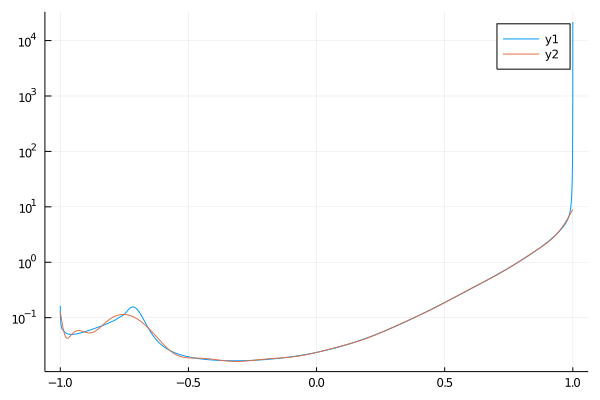

In [28]:
ftrunk = (aerosol_optics_trunc.k * aerosol_optics_trunc.ω̃)/(aerosol_optics_NAI2.k*aerosol_optics_NAI2.ω̃)
plot(μ, f₁₁, yscale=:log)
plot!(μ, tf₁₁*ftrunk, yscale=:log)

In [31]:
aerosol_optics_NAI2

AerosolOptics{Float64}
  greek_coefs: GreekCoefs{Float64}
  ω̃: Float64 0.7953832330041783
  k: Float64 70.77568760880087
  fᵗ: Float64 1.0
  derivs: Array{Float64}((1,)) [0.0]


In [34]:
GreekRayleigh = PhaseFunction.get_greek_rayleigh(0.0)

GreekCoefs{Float64}([0.0, 0.0, 3.0], [1.0, 0.0, 0.5], [0.0, 0.0, 1.224744871391589], [0.0, 1.5, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

In [ ]:
nQuad = 15
mu, w_mu = gausslegendre(2nQuad)
mu = mu[nQuad+1:end]
w_mu = w_mu[nQuad+1:end]
@show mu

In [47]:
using BenchmarkTools
m = 1 # Fourier Moment
𝐙⁺⁺, 𝐙⁻⁺ = PhaseFunction.compute_Z_moments(Stokes_IQUV(), mu, aerosol_optics_trunc.greek_coefs, m)

([2.477566271117174 0.00022129940760336973 … 0.0 0.0; 0.0002212994076033687 2.473022580546161 … 0.0 0.0; … ; 0.0 0.0 … 0.05490994895696321 -0.00041492439354728666; 0.0 0.0 … 0.0004149243935472865 19.337127820465362], [2.293272517068931 0.001976839093225921 … -0.0 -0.0; 0.001976839093225921 2.288245320854909 … -0.0 -0.0; … ; -0.0 -0.0 … 0.004952437572906598 0.0008148881819546417; -0.0 -0.0 … -0.000814888181954642 0.04697499805244526])

In [48]:
@show size(𝐙⁺⁺)

size(𝐙⁺⁺) = (60, 60)


(60, 60)

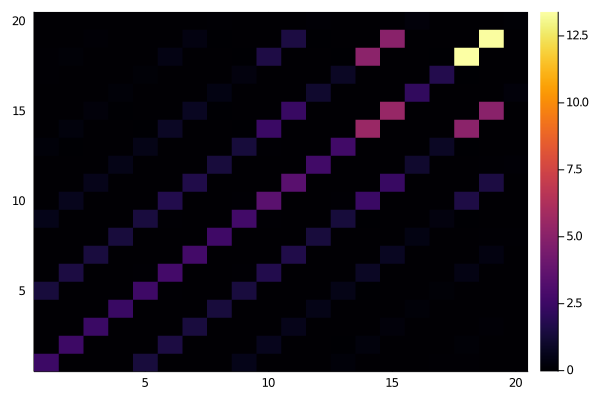

In [49]:
heatmap(𝐙⁺⁺[2:3:end,2:3:end])

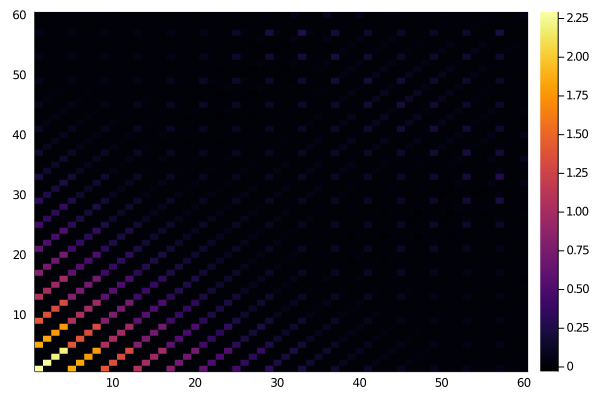

In [50]:
heatmap(𝐙⁻⁺)

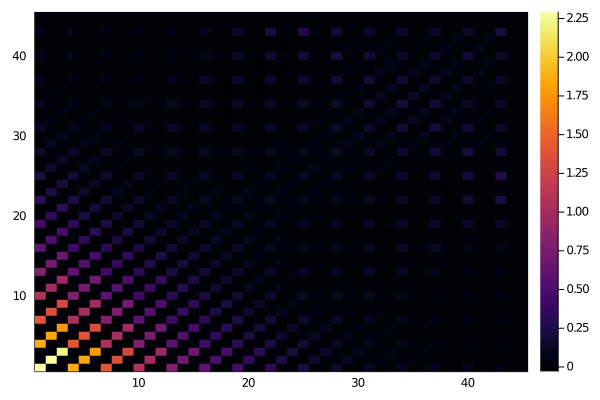

In [147]:
heatmap(𝐙⁺⁻)


In [154]:
using DelimitedFiles
atmgrid = readdlm("/Users/sanghavi/GDrive/code/github/atm_profiles/mon01lat05n.mpi")

37×12 Array{Any,2}:
   ";Combined"    "MPI"     "+"  …   "for"    "GOMETRAN++"   ""
   ";latitude"    "="      5         ""       ""             ""
   ";k"           "z"       "p"      "no3"    "hcho"         "oclo"
 34             60.6       0.19     0.0      3.116e-5       5.355e-6
 33             58.6       0.25     0.0      4.192e-5       2.595e-5
 32             56.5       0.33  …  0.0      5.639e-5       7.791e-5
 31             54.4       0.43     0.0      7.219e-5       7.249e-5
 30             52.2       0.58     0.0      8.946e-5       7.517e-5
 29             50.0       0.78     0.0      0.0001087      7.814e-5
 28             47.7       1.03     0.0      0.0001268      7.944e-5
 27             45.5       1.38  …  0.0      0.0001405      7.601e-5
 26             43.3       1.82     0.0      0.0001451      6.858e-5
 25             41.1       2.42     0.0      0.0001411      5.898e-5
  ⋮                              ⋱           ⋮              
 12             16.1      98.1   

In [54]:
include("atmo_prof.jl")
file = "/Users/sanghavi/GDrive/code/github/atm_profiles/MERRA300.prod.assim.inst6_3d_ana_Nv.20150613.hdf.nc4"   
timeIndex = 2 # There is 00, 06, 12 and 18 in UTC, i.e. 6 hourly data stacked together

# What latitude do we want? 
myLat = 34.1377;
myLon = -118.1253;

In [55]:
# Read profile (and generate dry/wet VCDs per layer)
profile_caltech = read_atmos_profile(file, myLat, myLon, timeIndex);


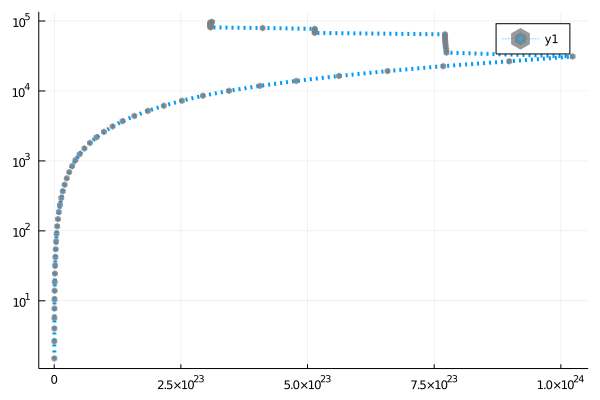

In [279]:
plot(profile_caltech.vcd_dry+profile_caltech.vcd_h2o, profile_caltech.p, line = (:dot, 4), marker = ([:hex :d], 2, 0.8, Plots.stroke(3, :gray)), yaxis=:log)

In [58]:
profile_caltech.vcd_dry

72-element Array{Float64,1}:
 2.117324159381013e20
 2.6889986318799543e20
 3.151633360421932e20
 3.899045055382667e20
 4.942883137461201e20
 6.427759180122127e20
 8.425241840307029e20
 1.0979150414819067e21
 1.4223525218917967e21
 1.8317994665379425e21
 2.3452486895895155e21
 2.9848487126893257e21
 3.7763451504935746e21
 ⋮
 3.064400823433368e23
 3.063849503609208e23
 3.063346357924367e23
 3.0631113991825e23
 3.062861309768607e23
 3.0624165920503014e23
 3.062212925017064e23
 3.06212084986099e23
 3.061755003821447e23
 3.061222260933986e23
 3.060776287972515e23
 3.089808995171043e23

In [236]:
include("types.jl")
include("RTM_main.jl")
#Using Ltrunc, SZA, and array of LZAs to determine RTM streams
Ltrunc = length(aerosol_optics_trunc.greek_coefs.β)
@show Ltrunc


Ltrunc = 20


20

In [237]:
Nquad, qp_μ, wt_μ = rt_set_streams(RadauQuad(), Ltrunc, 60.0, [0.0, 15.0, 30., 45., 60.])

(25, [0.0059588067162077984, 0.030866035938574038, 0.0735557248215351, 0.13057983800422812, 0.19731992344289342, 0.2683693828578303, 0.33797223083833255, 0.4004894605184494, 0.4508554938950734, 0.4849854839192568  …  0.6973199234428934, 0.7683693828578303, 0.8379722308383326, 0.9004894605184495, 0.9508554938950734, 0.9849854839192568, 1.0, 0.9659258262890683, 0.8660254037844386, 0.7071067811865476], [0.015231274453032781, 0.03425842053330057, 0.050540777135006106, 0.0627313444242821, 0.06984033327584575, 0.07129139098525183, 0.06696677154742099, 0.05721653096224421, 0.042829404801664944, 0.024961520476991964  …  0.06984033327584575, 0.07129139098525183, 0.06696677154742099, 0.05721653096224421, 0.042829404801664944, 0.024961520476991964, 0.004132231404958678, 0.0, 0.0, 0.0])

In [238]:
@show Nquad


Nquad = 25


25

In [239]:
@show length(wt_μ)

length(wt_μ) = 25


25

In [203]:
for i = 1:Nquad
@show i,qp_μ[i], wt_μ[i]
end

(i, qp_μ[i], wt_μ[i]) = (1, 0.0059588067162077984, 0.015231274453032781)
(i, qp_μ[i], wt_μ[i]) = (2, 0.030866035938574038, 0.03425842053330057)
(i, qp_μ[i], wt_μ[i]) = (3, 0.0735557248215351, 0.050540777135006106)
(i, qp_μ[i], wt_μ[i]) = (4, 0.13057983800422812, 0.0627313444242821)
(i, qp_μ[i], wt_μ[i]) = (5, 0.19731992344289342, 0.06984033327584575)
(i, qp_μ[i], wt_μ[i]) = (6, 0.2683693828578303, 0.07129139098525183)
(i, qp_μ[i], wt_μ[i]) = (7, 0.33797223083833255, 0.06696677154742099)
(i, qp_μ[i], wt_μ[i]) = (8, 0.4004894605184494, 0.05721653096224421)
(i, qp_μ[i], wt_μ[i]) = (9, 0.4508554938950734, 0.042829404801664944)
(i, qp_μ[i], wt_μ[i]) = (10, 0.4849854839192568, 0.024961520476991964)
(i, qp_μ[i], wt_μ[i]) = (11, 0.5, 0.004132231404958678)
(i, qp_μ[i], wt_μ[i]) = (12, 0.5059588067162077, 0.015231274453032781)
(i, qp_μ[i], wt_μ[i]) = (13, 0.5308660359385741, 0.03425842053330057)
(i, qp_μ[i], wt_μ[i]) = (14, 0.573555724821535, 0.050540777135006106)
(i, qp_μ[i], wt_μ[i]) = (15, 0.

In [261]:
τRayl =  getRayleighLayerOptProp(profile_caltech.psurf/100, .750, 0.0, profile_caltech.vcd_dry)


72-element Array{Float64,1}:
 2.729494285970581e-7
 3.4664538106648406e-7
 4.0628475383102285e-7
 5.026354208568651e-7
 6.37199137418092e-7
 8.286181346396825e-7
 1.0861185028824885e-6
 1.415349094718732e-6
 1.833589374559667e-6
 2.361417430961992e-6
 3.0233173645390075e-6
 3.847841375481174e-6
 4.868178764435514e-6
 ⋮
 0.0003950393944368992
 0.0003949683224518599
 0.00039490346071277766
 0.000394873171607516
 0.00039484093197036935
 0.0003947836023231537
 0.0003947573471084763
 0.0003947454774752286
 0.00039469831536875316
 0.0003946296381819949
 0.00039457214671831706
 0.0003983148239108262

In [262]:
sum(τRayl)

0.026651342677216756

In [263]:
profile_caltech.p_levels


73-element Array{Float64,1}:
     1.0
     2.000000238418579
     3.270000457763672
     4.758501052856445
     6.600001335144043
     8.934501647949219
    11.970301628112793
    15.949502944946289
    21.134902954101562
    27.85260581970215
    36.50410842895508
    47.58060836791992
    61.67790985107422
     ⋮
 81814.96780729294
 83268.37454896793
 84721.66567212343
 86174.95728356019
 87628.26473489776
 89081.4282925725
 90534.48402474076
 91987.52974714339
 93440.53629377112
 94893.43039095774
 96346.34307354689
 97813.4375

In [280]:
τAer = getAerosolLayerOptProp(1., 50000. ,5000.,profile_caltech.p_levels)

ρ[i] = 1.5450879775393235e-26
ρ[i] = 1.967251819769942e-26
ρ[i] = 2.3125863811799426e-26
ρ[i] = 2.8715743543408025e-26
ρ[i] = 3.6573760696245004e-26
ρ[i] = 4.785035315773142e-26
ρ[i] = 6.322127216256061e-26
ρ[i] = 8.324379941023403e-26
ρ[i] = 1.093005845316353e-25
ρ[i] = 1.4321977949991243e-25
ρ[i] = 1.8746786913238191e-25
ρ[i] = 2.454096653298905e-25
ρ[i] = 3.217443106640929e-25
ρ[i] = 4.2316939249942695e-25
ρ[i] = 5.608470934068693e-25
ρ[i] = 7.495151668077193e-25
ρ[i] = 1.0129932914135984e-24
ρ[i] = 1.3891749310227175e-24
ρ[i] = 1.940529332041994e-24
ρ[i] = 2.77348076519109e-24
ρ[i] = 4.076035667142334e-24
ρ[i] = 6.19482922567853e-24
ρ[i] = 9.797022762297136e-24
ρ[i] = 1.6233475463094485e-23
ρ[i] = 2.8392419454076956e-23
ρ[i] = 5.37285653080433e-23
ρ[i] = 1.1025929923726601e-22
ρ[i] = 2.484851136556106e-22
ρ[i] = 6.235392733875807e-22
ρ[i] = 1.7684329555561617e-21
ρ[i] = 5.759711264076934e-21
ρ[i] = 2.189968488418158e-20
ρ[i] = 1.0036499526489994e-19
ρ[i] = 5.630428876996545e-19
ρ[i

73-element Array{Float64,1}:
 0.0
 1.5438646584724727e-26
 1.965694253666649e-26
 2.310755397407522e-26
 2.8693007934105446e-26
 3.6544803523930837e-26
 4.781246777500609e-26
 6.317121689788228e-26
 8.317789136584046e-26
 1.0921404610080213e-25
 1.4310638564172487e-25
 1.873194419734982e-25
 2.4521536291659645e-25
 ⋮
 1.8716514757924603e-10
 2.822104523769858e-11
 3.911034797745267e-12
 4.981435356479603e-13
 5.830709062980089e-14
 6.2725946228204124e-15
 6.202632625295857e-16
 5.637196349745552e-17
 4.7086167810062245e-18
 3.6150435819790963e-19
 2.5508670368948707e-20
 1.6256475021082041e-21

In [59]:
profile_caltech.p


72-element Array{Float64,1}:
     1.5000001192092896
     2.6350003480911255
     4.014250755310059
     5.679251194000244
     7.767251491546631
    10.452401638031006
    13.959902286529541
    18.542202949523926
    24.493754386901855
    32.17835712432861
    42.0423583984375
    54.62925910949707
    70.59566116333008
     ⋮
 81088.21210205555
 82541.67117813043
 83995.02011054568
 85448.31147784181
 86901.61100922897
 88354.84651373513
 89807.95615865663
 91261.00688594207
 92714.03302045725
 94166.98334236443
 95619.88673225231
 97079.89028677344

In [60]:
[𝐙⁺⁻_aero1]

LoadError: UndefVarError: 𝐙⁺⁻ not defined